In [3]:
import sys
sys.path.append('/home/zmobille3/anaconda/envs/spike_env/lib/python310.zip')
sys.path.append('/home/zmobille3/anaconda/envs/spike_env/lib/python3.10')
sys.path.append('/home/zmobille3/anaconda/envs/spike_env/lib/python3.10/site-packages')
sys.path.append('/home/zmobille3/anaconda/envs/spike_env/lib/python3.10/lib-dynload')
from sklearn.feature_selection import f_regression, mutual_info_regression
from brian2 import *

In [4]:
### functions ###

# for partitioning data
def split_(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def getCountMI(stimulus,st,duration,T=50*ms):
    ## st is the full spike train ##
    
    # partition the stimulus data
    subStims = list(split_(stimulus,int(duration/T)))
    stimAvgs = []
    for i in range(len(subStims)):
        stimAvgs.append(np.mean(subStims[i]))
    #print(len(stimAvgs))

    # partition the spike train into spike counts
    counts = []
    spkVec = st.copy()
    ind = 1
    while len(spkVec) > 0:
        count = len(spkVec[spkVec<ind*T/ms])
        counts.append(count)
        spkVec = spkVec[spkVec>=T*ind/ms]
        ind+=1
    #print(len(counts))

    # add small noise to discrete spike count data to make it continuous
    from operator import add
    epsilon = np.random.normal(0,10**-4,size=len(counts))
    x = list( map(add, counts, epsilon) )
#     print('type(x) = '+str(type(x)))
    y = stimAvgs

    # get mutual information from the data processed above
    from sklearn.feature_selection import f_regression, mutual_info_regression
    nVec = [2,5,10,12,15,18,20] # number of non-overlapping subsets
    miVars = []
    # nVec = [50,100]
    sigma_KSG = 0.
    #     j = 0 # counter
    for n in nVec:
        mis = []
    #         print('splitting data into non-overlapping subsets of size '+str(subSize))
        xsub = list(split_(x,n))
        ysub = list(split_(y,n))
        for i in range(len(xsub)):
            xs = xsub[i]
            xs = np.reshape(xs,(len(xs),1))
            ys = ysub[i]
            mi = mutual_info_regression(xs, ys, n_neighbors=1)
            mis.append(mi)
        miVar = np.std(mis)**2
        add = miVar/n
        sigma_KSG += add
        miVars.append(miVar)
    x = np.reshape(x,(len(x),1))
    mean = mutual_info_regression(x, y, n_neighbors=1)[0]
    sigma = sigma_KSG
    return [mean, sigma]

# compute the rank of a spike train
def sTrainToRank(sTrain, delta_t, duration):
    """
    This function takes a spike train as input (a list of times when spikes occur)
    and returns a rank for that spike train by converting it to a binary sequence
    and converting that to a base 10 number.
    
    For example, a spike train sTrain = np.array([0.5,1.3,3.4,6.7,8.9,9.3]) would
    get converted to the string 1101001011 if a time bin delta_t=1 was used. This
    binary string would then be converted to 843 in base 10.
    
    sTrain = the list of spike times
    delta_t = the size of the time bin
    duration = the length of the time series to consider
    """
    Ts = int(duration) # consider time sequences of length 4*ms

    binTrain = np.zeros(Ts//delta_t)

    for j in range(len(binTrain)):
        state = int(0)
        for s in sTrain:
            condition = (s >= j*delta_t and s < (j+1)*delta_t)
            if condition:
                state = 1
        binTrain[j] = int(state)

    # convert the list binTrain to a string
    binTrainStr=""
    for i in binTrain:
        binTrainStr += str(int(i))

    # convert the binary sequence to a number in base 10
    binTrainBase10 = int(binTrainStr, 2)
    ret = [binTrainBase10, binTrainStr]
    return ret

def getTempMI_mean(stimulus,st,duration,T=50*ms):
    subStims = list(split_(stimulus,int(duration/T)))
    stimAvgs = []
    for i in range(len(subStims)):
        stimAvgs.append(np.mean(subStims[i]))
    duration = duration/ms
    ranks = []
    ranksGivenCount = {}
    stimAvgsGivenCount = {}
    spikeTrainDuration = T/ms
    delta_t = 5 # ms
    spkVec = st.copy()
    ind = 1
    while len(spkVec) > 0:
        sTrain = spkVec[spkVec<ind*T/ms] % spikeTrainDuration
    #     print(sTrain)
        count = len(sTrain)
#         counts.append(count)
        rank = sTrainToRank(sTrain, delta_t, spikeTrainDuration)[0]
        ranks.append(rank)
        key = f'{count}'
        if key in ranksGivenCount:
            ranksGivenCount[key].append(rank)
            stimAvgsGivenCount[key].append(stimAvgs[ind-1])
        else:
            ranksGivenCount[key] = []
            stimAvgsGivenCount[key] = []
            ranksGivenCount[key].append(rank)
            stimAvgsGivenCount[key].append(stimAvgs[ind-1])
    #     ranksGivenCount[f'{count}'] = np.append(ranksGivenCount[f'{count}'], rank)
        spkVec = spkVec[spkVec>=T*ind/ms]
        ind+=1
        
    MItemp = 0.
    tot = duration*ms/T # total number of spike trains
    for key in ranksGivenCount:
        probSC = len(ranksGivenCount[key])/tot
        x = ranksGivenCount[key]
#         print('len(x) = '+str(len(x)))
        x = np.reshape(x,(len(x),1))
        y = stimAvgsGivenCount[key]
        if len(x)>1: # don't use sub-samples with only 1 element
            mi = mutual_info_regression(x, y, n_neighbors=1)[0]
            MItemp+=probSC*mi
    return MItemp
    
# for generating the data
def generateData(duration,bottleneckSize):
    start_scope()
#     duration = duration*ms
    mu1 = -40*mV # mean of voltage threshold distribution (input layer group 1)
    mu2 = -60*mV # mean of voltage threshold distribution (input layer group 2)
    sigma = 6*mV # standard deviation of voltage threshold distribution (input layer)
    dt = defaultclock.dt
    #print('dt/ms ='+str(dt/ms))
    N = int(duration/dt)
    taut = 5*ms
    #s = np.random.normal(0, 1, N)
    #stimulus = TimedArray(s, dt=dt)
    Vr = -70*mV
    Vt0 = -50*mV
    tau = 10*ms
    Vdrive = 0.6*mV
    delta_Vt = 5*mV
    delta_V  = 10*mV
    CPGfreq = 20*Hz
    CPGamp = 0.5*mV
    tVec = np.arange(0,duration/ms,dt/ms)
    cpg = CPGamp*sin(2*pi*CPGfreq*tVec/(1000*Hz))
    CPG = TimedArray(cpg, dt=dt)

    # make a sine wave corrupted by small amplitude white noise
    #tVec = np.arange(0,duration,dt/ms)
    noise = np.random.normal(0,0.05,len(tVec))
    f1 = 5*Hz # frequency of I(t) in (Hz)
    f2 = 10*Hz
    f3 = 2*Hz
    # np.sin(2*pi*5*tvec/1000) + np.sin(2*pi*10*tvec/1000) - np.sin(2*pi*2*tvec/1000)
    det = 0.5*np.sin(2*np.pi*tVec*f1/(1000*Hz)) + 0.5*np.sin(2*np.pi*tVec*f2/(1000*Hz)) - 0.5*np.sin(2*np.pi*tVec*f3/(1000*Hz))
    signal = Vdrive*(det + noise)
    In = TimedArray(signal,dt)

    eqsI1 = '''
    dV/dt = (-V + Vt01 + In(t) + CPG(t))/tau : volt
    dVt/dt = (Vt01 - Vt)/taut : volt
    dVt01/dt = 0*mV/tau : volt
    '''

    eqsI2 = '''
    dV/dt = (-V + Vt02 - In(t) + CPG(t))/tau : volt
    dVt/dt = (Vt02 - Vt)/taut : volt
    dVt02/dt = 0*mV/tau : volt
    '''

    # these equations are for the rest of the neurons
    eqs = '''
    dV/dt = (Vt0 - V)/tau : volt
    dVt/dt = (Vt0 - Vt)/taut : volt
    '''
    # eqs = '''
    # dV/dt = (rand()*Vt0-V)/tau : volt
    # dVt/dt = (Vt0 - Vt)/taut : volt
    # '''

    reset = '''
    V = Vr
    Vt += delta_Vt
    '''

    # input group 1
    I1 = NeuronGroup(5, eqsI1, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
    I1.V = 'rand()*(Vt-Vr) + Vr'
    I1.Vt= Vt0
    I1.Vt01 = 'randn()*sigma + mu1'

    # input group 2
    I2 = NeuronGroup(5, eqsI2, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
    I2.V = 'rand()*(Vt-Vr) + Vr'
    I2.Vt= Vt0
    I2.Vt02 = 'randn()*sigma + mu2'

    # first expansion
    E1 = NeuronGroup(10000, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler') # 'I' for "input"
    E1.V = 'rand()*(Vt-Vr)+Vr' # random initial states
    E1.Vt = Vt0

    # bottleneck
    B = NeuronGroup(bottleneckSize, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
    B.V = 'rand()*(Vt-Vr) + Vr'
    B.Vt= Vt0

    # second expansion
    E2 = NeuronGroup(10000, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler') # 'I' for "input"
    E2.V = 'rand()*(Vt-Vr)+Vr' # random initial states
    E2.Vt = Vt0

    # output neurons (10 moth muscles)
    O = NeuronGroup(10, eqs, threshold='V>Vt', refractory=5*ms, reset=reset, method='euler')
    O.V = 'rand()*(Vt-Vr) + Vr'
    O.Vt= Vt0

    # specify synapses from input layer 1 to first expansion layer
    I1_E1 = Synapses(I1, E1, model='''w : 1''', on_pre='V_post += w*delta_V-0.4*mV')
    I1_E1.connect(p=0.1)
    I1_E1.w[:, :] = 'rand()'

    # specify synapses from input layer 2 to first expansion layer
    I2_E1 = Synapses(I2, E1, model='''w : 1''', on_pre='V_post += w*delta_V-0.4*mV')
    I2_E1.connect(p=0.1)
    I2_E1.w[:, :] = 'rand()'

    # specify synapses from first expansion layer to bottleneck
    E1_B = Synapses(E1, B, model='''w : 1''', on_pre='V_post += w*delta_V-0.4*mV')
    E1_B.connect(p=0.1)
    E1_B.w[:, :] = 'rand()'

    # specify synapses from bottleneck to second expansion layer
    B_E2 = Synapses(B, E2, model='''w : 1''', on_pre='V_post += w*delta_V-0.4*mV')
    B_E2.connect(p=0.1)
    B_E2.w[:, :] = 'rand()'

    # specify synapses from second expansion layer to final output layer
    E2_O = Synapses(E2, O, model='''w : 1''', on_pre='V_post += w*delta_V-0.4*mV')
    E2_O.connect(p=0.1)
    E2_O.w[:, :] = 'rand()'

    mon = StateMonitor(I1, ['V'], record=True)
    I1mon = SpikeMonitor(I1)
    I2mon = SpikeMonitor(I2)
    E1mon = SpikeMonitor(E1)
    Bmon  = SpikeMonitor(B)
    E2mon = SpikeMonitor(E2)
    Omon = SpikeMonitor(O)

    run(duration)
    return [signal/mV,Bmon,Omon] # return the bottleneck and output neuron spikes

In [5]:
# loop through bottleneck sizes
MIratios_bottleneck = []
MIratios_output = []
# MItemp_vars
bottleneckSizeVec = [400,500,600,700,800,900,1000]
duration = 25000*ms # ms
for bottleneckSize in bottleneckSizeVec:
    print(bottleneckSize)
    data = generateData(duration,bottleneckSize)
    # process data
    stimulus = data[0]
    bottleneckSpikes = data[1]
    outputSpikes = data[2]
    bottleneckTimes = bottleneckSpikes.t/ms
    bottleneckIndices=bottleneckSpikes.i
    outputTimes = outputSpikes.t/ms
    outputIndices=outputSpikes.i
    stBottle = bottleneckTimes[bottleneckIndices==0]
    stOutput = outputTimes[outputIndices==0]
    countMI_mean_bottle, countMI_var_bottle = getCountMI(stimulus,stBottle,duration)
    countMI_mean_output, countMI_var_output = getCountMI(stimulus,stOutput,duration)
    tempMI_bottle = getTempMI_mean(stimulus,stBottle,duration)
    tempMI_output = getTempMI_mean(stimulus,stOutput,duration)
    MIratio_bottleneck = tempMI_bottle/countMI_mean_bottle
    MIratio_output = tempMI_output/countMI_mean_output
    MIratios_bottleneck.append(MIratio_bottleneck)
    MIratios_output.append(MIratio_output)

400
500
600
700
800
900
1000


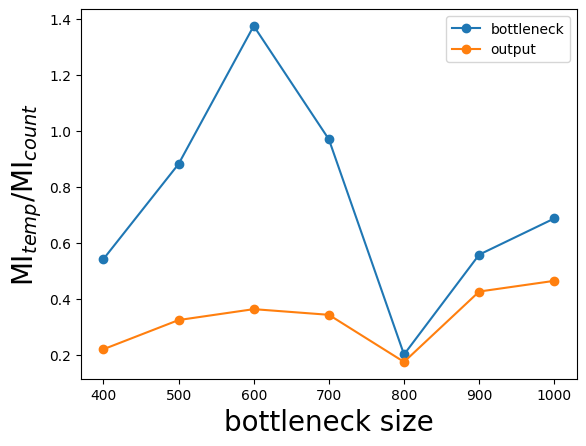

In [6]:
# plt.errorbar(bottleneckSizeVec,MIcount_means,yerr=MIcount_vars,marker='o',label='count')
plt.plot(bottleneckSizeVec,MIratios_bottleneck,marker='o',label='bottleneck')
plt.plot(bottleneckSizeVec,MIratios_output,marker='o',label='output')
plt.xlabel('bottleneck size',fontsize=20)
plt.ylabel(r'MI$_{temp}$/MI$_{count}$',fontsize=20)
plt.legend()
plt.savefig('MItempMIcount_bottleVSoutput_10k.png',bbox_inches='tight',dpi=200)
plt.show()